## Load packages

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn import datasets, metrics, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier

In [2]:
# Set working directory
# folder_path = '/path/to/your/folder'
# file_name = 'survey.csv'
# file_path = os.path.join(folder_path, file_name)
# df = pd.read_csv(file_path)

# Load data
df = pd.read_csv('survey.csv')
df

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN


## Data preprocessing

In [3]:
# Sorting user inputs to match the desired gender groups
def clean_gender(df):
    # Select unique elements
    gender = df['Gender'].unique()

    # Make gender groups
    male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
    other_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
    female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

    for (row, col) in df.iterrows():

        if str.lower(col.Gender) in male_str:
            df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

        if str.lower(col.Gender) in female_str:
            df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

        if str.lower(col.Gender) in other_str:
            df['Gender'].replace(to_replace=col.Gender, value='other', inplace=True)
            
    stk_list = ['A little about you', 'p']
    df = df[~df['Gender'].isin(stk_list)]

    print(df['Gender'].unique())

    return df

In [4]:
# Drop unrealistic age values
df = df[df['Age'].between(0, 100)]

# Handling missing values with default assignments
df['work_interfere'] = df['work_interfere'].fillna('Don\'t know')
df['self_employed'] = df['self_employed'].fillna('No')

# Dropping unnecessary columns
df.drop(['state', 'Timestamp', 'comments'], axis=1, inplace=True)

# Print unique values to verify fillna operations
print('Unique values in work_interfere:', df['work_interfere'].unique())
print('Unique values in self_employed:', df['self_employed'].unique())

# Print DataFrame columns and check for remaining missing values
print('DataFrame columns:', df.columns)
print('Missing values in each column:\n', df.isnull().sum())

# Cleaning up the gender column
df = clean_gender(df)

# Calculate mean and standard deviation of age by gender
gender_desc = df.groupby('Gender')['Age'].agg(['mean', 'std'])
print('Age mean and sd per gender:\n', gender_desc)

# Print gender stats
unique_genders = df['Gender'].value_counts()
print(unique_genders)

# Scaling Age and creating a new column for it
scaler = MinMaxScaler()

df['Scaled_Age'] = scaler.fit_transform(df[['Age']])

# Display the first few rows to verify changes
df.head()


/tmp/ipykernel_642/560840185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['work_interfere'] = df['work_interfere'].fillna('Don\'t know')
/tmp/ipykernel_642/560840185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['self_employed'] = df['self_employed'].fillna('No')
/tmp/ipykernel_642/560840185.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Unique values in work_interfere: ['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]
Unique values in self_employed: ['No' 'Yes']
DataFrame columns: Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')
Missing values in each column:
 Age                          0
Gender                       0
Country                      0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_o

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Scaled_Age
0,37,female,United States,No,No,Yes,Often,6-25,No,Yes,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,0.477612
1,44,male,United States,No,No,No,Rarely,More than 1000,No,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,0.582090
2,32,male,Canada,No,No,No,Rarely,6-25,No,Yes,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,0.402985
3,31,male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,0.388060
4,31,male,United States,No,No,No,Never,100-500,Yes,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,0.388060


In [5]:
# Manually specifying the order for categorical variables
manual_orders = {
    'work_interfere': {"Never": 0, "Rarely": 1, "Don't know": 2, "Sometimes": 3, "Often": 4},
    'no_employees': {'1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5},
    'leave': {'Very easy': 0, 'Somewhat easy': 1, "Don't know": 2, 'Somewhat difficult': 3, 'Very difficult': 4}
}
# Standard response mappings
standard_mapping = {'No': 0, 'Yes': 2}
standard_features = ['self_employed', 'remote_work', 'tech_company', 'obs_consequence']  # 'No', 'Yes' answer types

# Extended mappings for features that include responses like 'Maybe' or 'Don't know'
extended_response_mapping = {'No': 0, 'Yes': 2,'Maybe': 1, "Don't know": 1, "Not sure": 1} # Treating 'Maybe' and 'Don't know' similarly
extended_features = ['mental_health_consequence', 'phys_health_consequence', 
                     'mental_health_interview', 'phys_health_interview', 
                     'mental_vs_physical', 'seek_help', 'benefits', 'wellness_program', 
                     'anonymity']  # 'No', 'Yes', 'Maybe', "Don't know" answer types

# Specific mapping for features including 'Some of them'
some_of_them_mapping = {'No': 0, 'Some of them': 1, 'Yes': 2}
some_of_them_features = ['coworkers', 'supervisor']  # 'No', 'Some of them', 'Yes' answer types


# Label encoding with manual control for ordinal data
label_dict = {}

for feature in df.columns:
    label_key = 'label_' + feature

    if feature in manual_orders:
        # Apply manual mapping
        df[feature] = df[feature].map(manual_orders[feature])
        label_value = list(manual_orders[feature].items())  # Store the manual order used
    elif feature in standard_features:
        df[feature] = df[feature].map(standard_mapping)
        label_value = standard_mapping
    elif feature in extended_features:
        df[feature] = df[feature].map(extended_response_mapping)
        label_value = extended_response_mapping
    elif feature in some_of_them_features:
        df[feature] = df[feature].map(some_of_them_mapping)
        label_value = some_of_them_mapping
    else:
        # Use automatic label encoding for other categorical features
        le = preprocessing.LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        label_value = [le_name_mapping]

    label_dict[label_key] = label_value

# Print label mappings for each feature
for key, value in label_dict.items():
    print(key, value)

label_Age [{5: 0, 11: 1, 18: 2, 19: 3, 20: 4, 21: 5, 22: 6, 23: 7, 24: 8, 25: 9, 26: 10, 27: 11, 28: 12, 29: 13, 30: 14, 31: 15, 32: 16, 33: 17, 34: 18, 35: 19, 36: 20, 37: 21, 38: 22, 39: 23, 40: 24, 41: 25, 42: 26, 43: 27, 44: 28, 45: 29, 46: 30, 47: 31, 48: 32, 49: 33, 50: 34, 51: 35, 53: 36, 54: 37, 55: 38, 56: 39, 57: 40, 58: 41, 60: 42, 61: 43, 62: 44, 65: 45, 72: 46}]
label_Gender [{'female': 0, 'male': 1, 'other': 2}]
label_Country [{'Australia': 0, 'Austria': 1, 'Belgium': 2, 'Bosnia and Herzegovina': 3, 'Brazil': 4, 'Bulgaria': 5, 'Canada': 6, 'China': 7, 'Colombia': 8, 'Costa Rica': 9, 'Croatia': 10, 'Czech Republic': 11, 'Denmark': 12, 'Finland': 13, 'France': 14, 'Georgia': 15, 'Germany': 16, 'Greece': 17, 'Hungary': 18, 'India': 19, 'Ireland': 20, 'Israel': 21, 'Italy': 22, 'Japan': 23, 'Latvia': 24, 'Mexico': 25, 'Moldova': 26, 'Netherlands': 27, 'New Zealand': 28, 'Nigeria': 29, 'Norway': 30, 'Philippines': 31, 'Poland': 32, 'Portugal': 33, 'Romania': 34, 'Russia': 35, 

## Modelling

In [6]:
# Model estimation

performances = []

def basic_class_evaluate(model, X, y, nsplit, model_name, threshold=0.5, constant_value=None):
    ''' Evaluates the performance of a classification model or a constant baseline.
    Args:
        model (sklearn.Estimator): fitted sklearn estimator, can be None if constant_value is used
        X (np.array): predictors, not used if constant_value is provided
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        threshold (float): cutoff value to determine class labels for binary classifications
        constant_value (int or None): relevant if evaluating a constant prediction
    '''
    if constant_value is not None:
        # Use a constant value for all predictions if provided
        preds = np.array([constant_value] * y.shape[0])
    else:
        # Obtain probabilities for the positive class and determine class predictions based on the threshold
        probas = model.predict_proba(X)[:, 1]
        preds = (probas >= threshold).astype(int)
    
    # Compute classification metrics
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds, zero_division=0)
    recall = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    auc = roc_auc_score(y, probas) if constant_value is None else None  # ROC AUC is not meaningful for constant predictions
    
    # Append to a global list to track performances across models
    performances.append({
        'model': model_name,
        'split': nsplit,
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1': round(f1, 4),
        'auc': round(auc, 4) if auc is not None else 'N/A'  # Handling None for AUC in case of constant prediction
    })


In [7]:
# Detailed evaluation function
def detailed_evaluate(model, X_test, y_test, y_pred):
    """
    Evaluate the performance of a classification model on the test set.

    Parameters:
    - model: The trained model used for prediction.
    - X_test: The feature data for testing.
    - y_test: The true labels for the test data.
    - y_pred: The predicted labels from the model.

    This function prints out:
    - The percentage of ones and zeros in the true labels.
    - The first 25 true and predicted labels for comparison.
    - The confusion matrix and its components (TP, TN, FP, FN).
    - The balanced accuracy and F1 score.
    - The classification accuracy.

    Additionally, it visualizes the confusion matrix and plots the ROC curve if applicable.
    """
    # Calculate the percentage of ones
    print(f'Percentage of ones: {(round(y_test.mean() * 100, 2))} %')
    
    # Calculate the percentage of zeros
    print(f'Percentage of zeros: {(round((1 - y_test.mean()) * 100, 2))} %')
    
    # Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred[0:25])
    
    # Confusion matrix
    # Save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred)

    # [row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Balanced accuracy and F1 score
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    bal_accuracy = (precision + recall) / 2
   
    f1 = ((precision * recall) / (precision + recall)) * 2
    print('F1 score: ', round(f1, 2))

    # Classification accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    print('Classification accuracy: ', round(accuracy, 2))
    
    # Visualise Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d", cmap='Purples') 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC Curve (if applicable)
    if len(np.unique(y_test)) == 2:  # Check if binary classification
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
        auc = metrics.roc_auc_score(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, color='purple', label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

In [8]:
# Using scaled age
feature_cols = ['Scaled_Age', 'Gender', 'family_history', 'benefits', 'care_options', 'work_interfere']

In [9]:
X = df.drop('treatment', axis=1) # Defining it as all the columns excl. treatment
y = df['treatment']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Further splitting the training set into a training and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

### Dummy baseline model

In [10]:
# Calculating the most frequent class in the training data
values, counts = np.unique(y_train, return_counts=True)
most_frequent_class = int(values[np.argmax(counts)])

# Using the most frequent class as the constant value for predictions in evaluations
for x, y, nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
    basic_class_evaluate(model=None, 
                         X=x, y=y, 
                         nsplit=nsplit, 
                         model_name='log-majority-class-baseline (dummy)',
                         constant_value=most_frequent_class)

### Logistic Regression

#### Demographics baseline

Cross-validation scores (scoring with accuracy): [0.71052632 0.69333333 0.78666667 0.66666667 0.58666667 0.66666667
 0.74666667 0.69333333 0.62666667 0.61333333]
Mean cross-validation score (scoring with accuracy): 0.6790526315789474
Cross-validation scores (scoring with f1): [0.67647059 0.65671642 0.78947368 0.62686567 0.56338028 0.62686567
 0.74666667 0.63492063 0.6        0.60273973]
Mean cross-validation score (scoring with f1): 0.6524099342944688
Percentage of ones: 57.37 %
Percentage of zeros: 42.63 %
True: [0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
Pred: [0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1]
F1 score:  0.7
Classification accuracy:  0.7


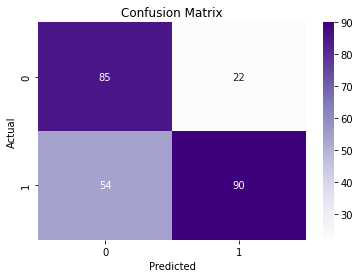

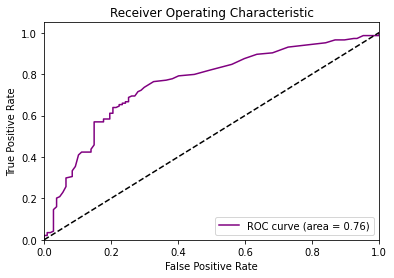

In [11]:
# Taking the demographic columns
dem_cols = ['Scaled_Age', 'Gender', 'family_history']

reg = LogisticRegression(max_iter=200)

# Set up stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and compute the scores
cv_scores_accuracy = cross_val_score(reg, X_train[dem_cols], y_train, cv=kf, scoring='accuracy')
cv_scores_f1 = cross_val_score(reg, X_train[dem_cols], y_train, cv=kf, scoring='f1')

print(f"Cross-validation scores (scoring with accuracy): {cv_scores_accuracy}")
print(f"Mean cross-validation score (scoring with accuracy): {cv_scores_accuracy.mean()}")
print(f"Cross-validation scores (scoring with f1): {cv_scores_f1}")
print(f"Mean cross-validation score (scoring with f1): {cv_scores_f1.mean()}")

# Fit log reg on the training dataset
reg.fit(X_train[dem_cols], y_train)

for x,y,nsplit in zip([X_train, X_val, X_test],
                      [y_train, y_val, y_test],
                      ['train', 'val', 'test']):
    basic_class_evaluate(model=reg, 
             X=x[dem_cols], y=y, 
             nsplit=nsplit, 
             model_name='log-demographic')

y_pred = reg.predict(X_test[dem_cols])

detailed_evaluate(model = reg, X_test=X_test[dem_cols], y_test=y_test, y_pred=y_pred)

#### Full model

Cross-validation scores (scoring with accuracy): [0.81578947 0.85333333 0.81333333 0.65333333 0.8        0.66666667
 0.78666667 0.68       0.77333333 0.74666667]
Mean cross-validation score (scoring with accuracy): 0.7589122807017545
Cross-validation scores (scoring with f1): [0.80555556 0.85333333 0.81578947 0.64864865 0.81012658 0.64788732
 0.78378378 0.65714286 0.76712329 0.74666667]
Mean cross-validation score (scoring with f1): 0.7536057512708431
Percentage of ones: 57.37 %
Percentage of zeros: 42.63 %
True: [0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
Pred: [0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1]
F1 score:  0.76
Classification accuracy:  0.73


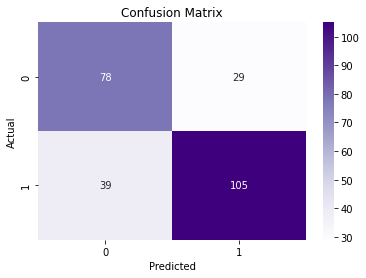

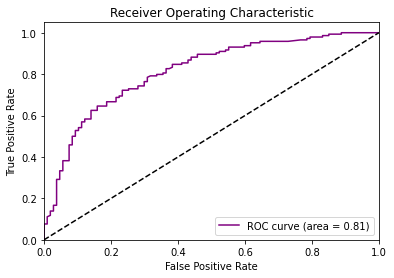

In [12]:
# Always only edit 'feature_cols' in the top where it's defined first
# This ensures that it's consistent what we're using across models

reg = LogisticRegression(max_iter=200)

# Set up stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and compute the scores
cv_scores_accuracy = cross_val_score(reg, X_train[feature_cols], y_train, cv=kf, scoring='accuracy')
cv_scores_f1 = cross_val_score(reg, X_train[feature_cols], y_train, cv=kf, scoring='f1')

print(f"Cross-validation scores (scoring with accuracy): {cv_scores_accuracy}")
print(f"Mean cross-validation score (scoring with accuracy): {cv_scores_accuracy.mean()}")
print(f"Cross-validation scores (scoring with f1): {cv_scores_f1}")
print(f"Mean cross-validation score (scoring with f1): {cv_scores_f1.mean()}")

# Fit log reg to training dataset
reg.fit(X_train[feature_cols], y_train)

for x,y,nsplit in zip([X_train[feature_cols], X_val[feature_cols], X_test[feature_cols]],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    basic_class_evaluate(model=reg, 
                X=x[feature_cols], y=y, 
                nsplit=nsplit, 
                model_name='log-full-model')

y_pred = reg.predict(X_test[feature_cols])

detailed_evaluate(model = reg, X_test=X_test[feature_cols], y_test=y_test, y_pred=y_pred)

### Tree-based models

In [13]:
# Defining all this again, to make sure that it didn't get accidentally get ovrwritten
tree_feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'work_interfere']


# Always only edit 'feature_cols' in the top where it's defined first, so we can make sure that it's consistent what we're using
X = df[tree_feature_cols]
y = df['treatment']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Let's further split the training set into a training and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

#### Random forest

In [14]:
# Define a grid of hyperparameters to search for the best combination
param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.3, 0.6, 0.9],
    'ccp_alpha': [0.01, 0.1, 1.0]
}

# Initialize the Random Forest Classifier with a fixed random state for reproducibility
rfclf = RandomForestClassifier(random_state=42)

##### Accuracy

Best parameters:  {'bootstrap': True, 'ccp_alpha': 0.01, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
[0.00416372 0.02013562 0.16202066 0.02366276 0.04501143 0.7450058 ]


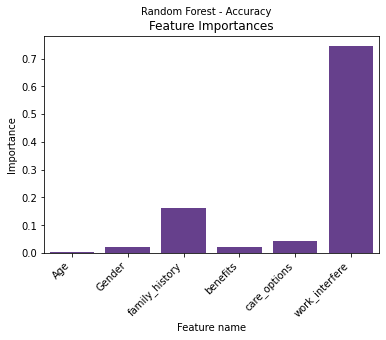

Percentage of ones: 57.37 %
Percentage of zeros: 42.63 %
True: [0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
Pred: [0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1]
F1 score:  0.85
Classification accuracy:  0.82


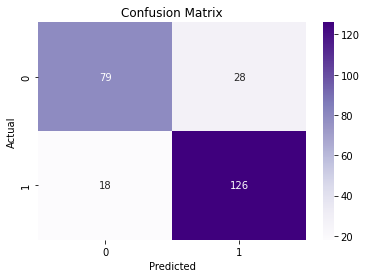

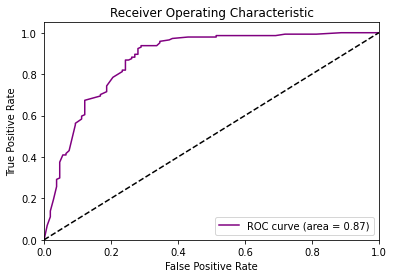

ValueError: operands could not be broadcast together with shapes (6,) (251,2) 

In [50]:
# Hyperparameter tuning
cv_rf = RandomizedSearchCV(estimator=rfclf, 
                            param_distributions=param_grid,
                            scoring='accuracy',
                            n_iter=200, # 200 iterations
                            cv=5,
                            random_state=42)
cv_rf.fit(X_train, y_train)

# Check best parameters
print('Best parameters: ', cv_rf.best_estimator_.get_params())

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Evaluate
    basic_class_evaluate(model=cv_rf.best_estimator_, 
    X=x, y=y,
    nsplit=nsplit,
    model_name='random-forest-accuracy')

# Feature importances
importances = cv_rf.best_estimator_.feature_importances_
print(importances)

sns.barplot(x=X.columns.tolist(), y=importances, color='rebeccapurple')
plt.title('Feature Importances')
plt.suptitle('Random Forest - Accuracy', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.savefig('plots/analysis/feature_importances_rf_acc.png')
plt.show()

# Detailed evaluation
predicted = cv_rf.predict(X_test)
detailed_evaluate(model = cv_rf, X_test=X_test[tree_feature_cols], y_test=y_test, y_pred=predicted)


##### F1

In [15]:
# Hyperparameter tuning
cv_rf = RandomizedSearchCV(estimator=rfclf, 
                            param_distributions=param_grid,
                            scoring='f1',
                            n_iter=200, # Trying with 200, but if it's bad, try 150.
                            cv=5,
                            random_state=42)
cv_rf.fit(X_train, y_train)

# Check best parameters
print('Best parameters: ', cv_rf.best_estimator_.get_params())

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Evaluate
    basic_class_evaluate(model=cv_rf.best_estimator_, 
    X=x, y=y,
    nsplit=nsplit,
    model_name='random-forest-f1')

# Feature importances
importances = cv_rf.best_estimator_.feature_importances_
print(importances)

sns.barplot(x=X.columns.tolist(), y=importances, color='rebeccapurple')
plt.title('Feature Importances')
plt.suptitle('Random Forest - F1', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.savefig('plots/analysis/feature_importances_rf_f1.png')
plt.show()

# Detailed evaluation
predicted = cv_rf.predict(X_test)
detailed_evaluate(model = cv_rf, X_test=X_test[tree_feature_cols], y_test=y_test, y_pred=predicted)

KeyboardInterrupt: 

#### Decision trees

In [98]:
# Define a dictionary of hyperparameters for tuning
parameters = {'max_depth': range(1,10), 
              'min_samples_split': np.arange(2,100,10),
              'ccp_alpha': [0.01, 0.1, 1.0, 10.0]}

# Optionally evaluate other metrics
# print('Test Accuracy:', accuracy_score(y_test, predicted))
# print('Test F1 Score:', f1_score(y_test, predicted, average='macro'))  # adjust average as needed

##### Accuracy

Best estimators:  {'ccp_alpha': 0.01, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 22, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
[0.         0.         0.05907493 0.         0.         0.94092507]


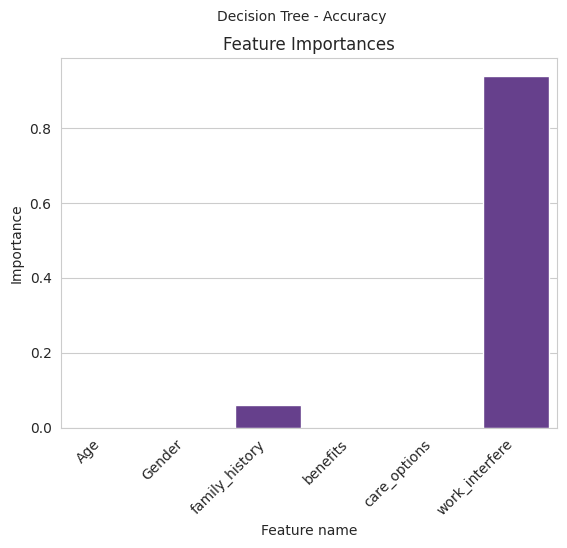

Percentage of ones: 57.37 %
Percentage of zeros: 42.63 %
True: [0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
Pred: [0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1]
F1 score:  0.84
Classification accuracy:  0.82


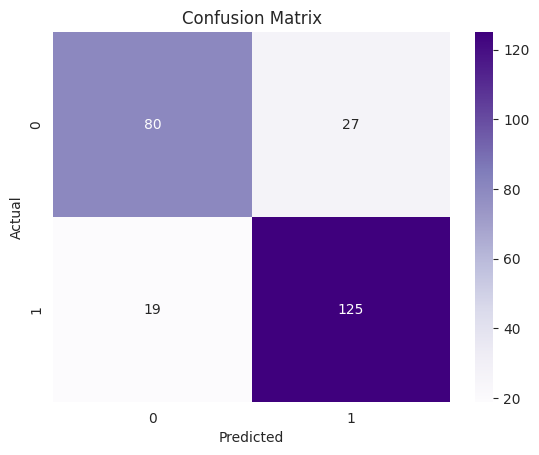

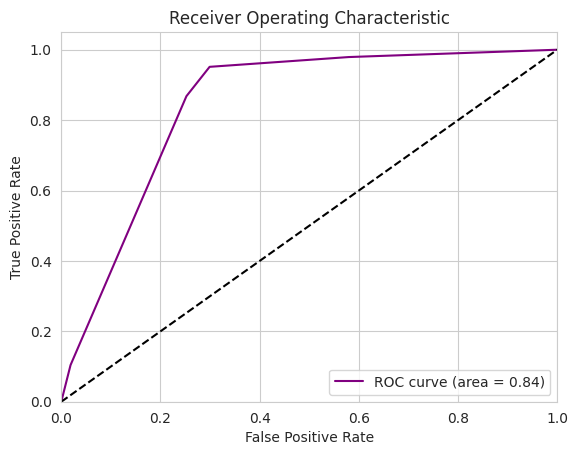

In [99]:
# Perform hyperparameter tuning using RandomizedSearchCV with a DecisionTreeClassifier based on accuracy
clf = RandomizedSearchCV(DecisionTreeClassifier(), 
                   parameters, 
                   n_jobs=1, 
                   scoring='accuracy', 
                   cv=5,
                   random_state=42)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_

print('Best estimators: ', clf.best_estimator_.get_params()) 

# Loop over the training, validation, and test datasets to evaluate the best model
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Evaluate
    basic_class_evaluate(model=tree_model, 
    X=x, y=y,
    nsplit=nsplit,
    model_name='decision-tree-accuracy')

# Extract feature importances from the best estimator of the tuned model
importances = clf.best_estimator_.feature_importances_
print(importances)

# Plotting the feature importances
sns.barplot(x=X.columns.tolist(), y=importances, color='rebeccapurple')
plt.title('Feature Importances')
plt.suptitle('Decision Tree - Accuracy', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.savefig('plots/analysis/feature_importances_dt_acc.png')
plt.show()

# Detailed evaluation
predicted = tree_model.predict(X_test)
detailed_evaluate(model = clf, X_test=X_test[tree_feature_cols], y_test=y_test, y_pred=predicted)

##### F1

Best estimators:  {'ccp_alpha': 0.01, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 72, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
[0.         0.         0.05907493 0.         0.         0.94092507]


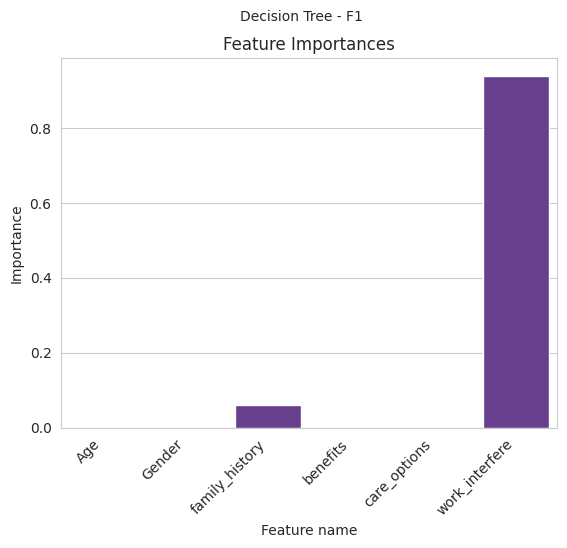

Percentage of ones: 57.37 %
Percentage of zeros: 42.63 %
True: [0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
Pred: [0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1]
F1 score:  0.84
Classification accuracy:  0.82


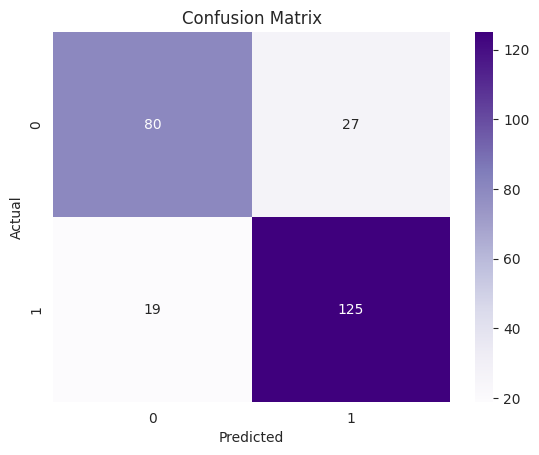

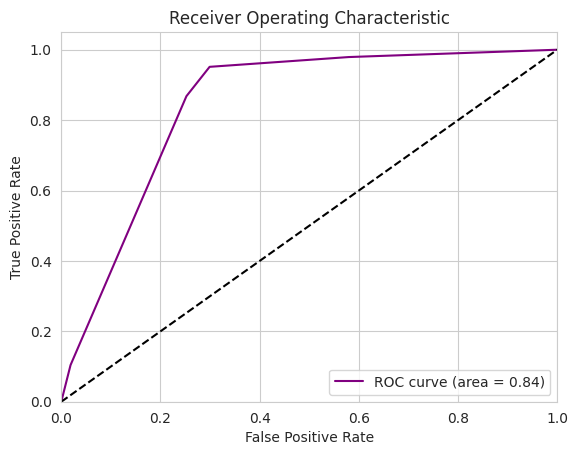

In [100]:
# Perform hyperparameter tuning using RandomizedSearchCV with a DecisionTreeClassifier based on f1
clf = RandomizedSearchCV(DecisionTreeClassifier(), 
                   parameters, 
                   n_jobs=1, 
                   scoring='f1', 
                   cv=5,
                   random_state=42)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_

print('Best estimators: ', clf.best_estimator_.get_params()) 

# Loop over the training, validation, and test datasets to evaluate the best model
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Evaluate
    basic_class_evaluate(model=tree_model, 
    X=x, y=y,
    nsplit=nsplit,
    model_name='decision-tree-f1')

# Extract feature importances from the best estimator of the tuned model
importances = clf.best_estimator_.feature_importances_
print(importances)

# Plotting feature importances
sns.barplot(x=X.columns.tolist(), y=importances, color='rebeccapurple')
plt.title('Feature Importances')
plt.suptitle('Decision Tree - F1', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.savefig('plots/analysis/feature_importances_dt_f1.png')
plt.show()

# Detailed evaluation
predicted = tree_model.predict(X_test)
detailed_evaluate(model = clf, X_test=X_test[tree_feature_cols], y_test=y_test, y_pred=predicted)

#### XG Boost

In [101]:
# Initialize an XGBoost classifier with a fixed random state for reproducibility
xgb_clf = XGBClassifier(random_state=42) # Other parameters??

# Define a grid of hyperparameters to search for the best combination for the XGBoost classifier
param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'objective': ['binary:logistic'], # For binary classification
    'colsample_bytree': [0.3, 0.6, 0.9],
    'learning_rate': [2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
}

##### Accuracy

Best Parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 2, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 20, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
[0.01169204 0.08336829 0.33844134 0.08705858 0.07747346 0.4019663 ]


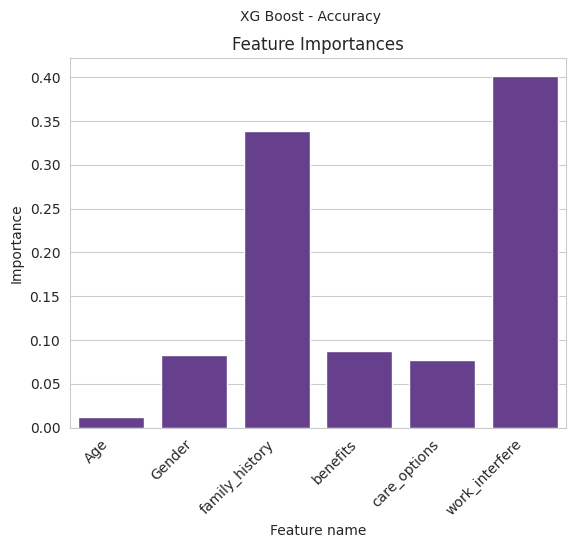

Percentage of ones: 57.37 %
Percentage of zeros: 42.63 %
True: [0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
Pred: [0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1]
F1 score:  0.86
Classification accuracy:  0.84


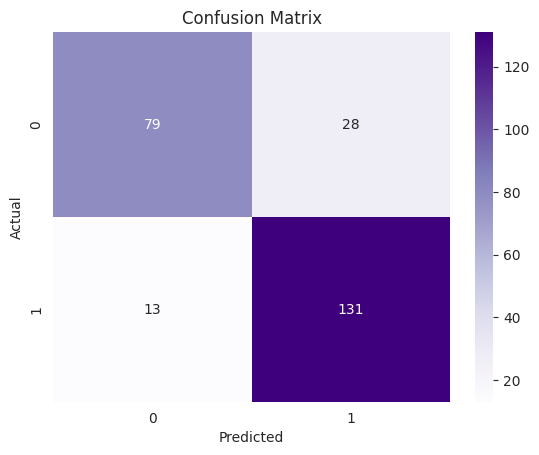

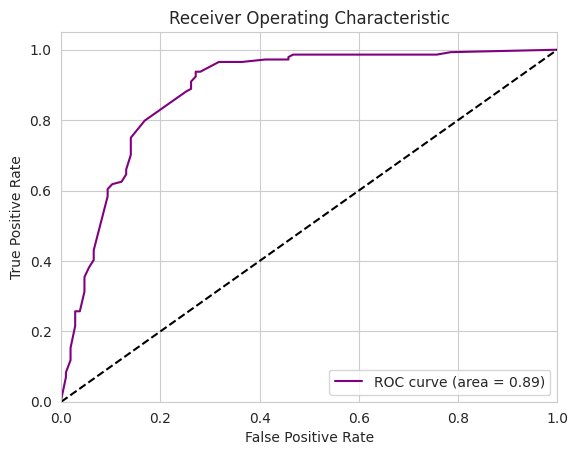

In [102]:
# Perform hyperparameter tuning using RandomizedSearchCV with the XGBoost classifier
cv_xgb = RandomizedSearchCV(estimator=xgb_clf, 
                            param_distributions=param_grid,
                            scoring='accuracy',
                            n_iter=200, # Trying with 200, but if it's bad, try 150.
                            cv=5,
                            random_state=42)
# Fit the RandomizedSearchCV to the training data
cv_xgb.fit(X_train, y_train)

print('Best Parameters:', cv_xgb.best_estimator_.get_params())

# Loop over the training, validation, and test datasets to evaluate the best XGBoost model
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Evaluate
    basic_class_evaluate(model=cv_xgb.best_estimator_, 
    X=x, y=y,
    nsplit=nsplit,
    model_name='xg-boost-accuracy')

# Extract feature importances from the best estimator of the tuned XGBoost model
importances = cv_xgb.best_estimator_.feature_importances_
print(importances)

# Plotting the feature importances
sns.barplot(x=X.columns.tolist(), y=importances, color='rebeccapurple')
plt.title('Feature Importances')
plt.suptitle('XG Boost - Accuracy', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.savefig('plots/analysis/feature_importances_xg_acc.png')
plt.show()

# Detailed evaluation
predicted = cv_xgb.predict(X_test)
detailed_evaluate(model = cv_xgb, X_test=X_test[tree_feature_cols], y_test=y_test, y_pred=predicted)

##### F1

Best Parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
[0.01704328 0.08221899 0.2398882  0.05457336 0.08277315 0.523503  ]


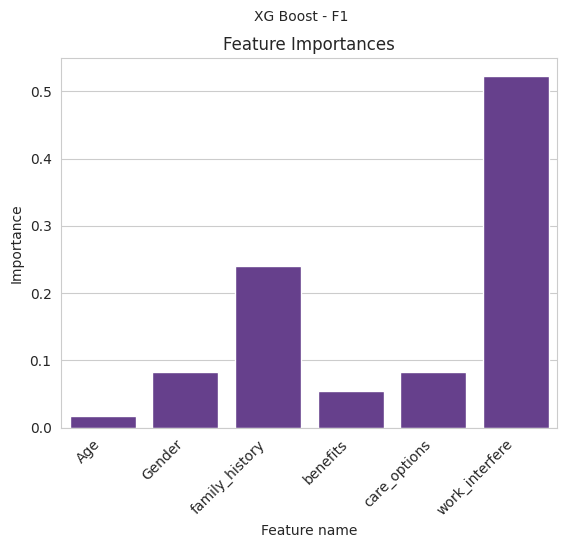

Percentage of ones: 57.37 %
Percentage of zeros: 42.63 %
True: [0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
Pred: [0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1]
F1 score:  0.87
Classification accuracy:  0.84


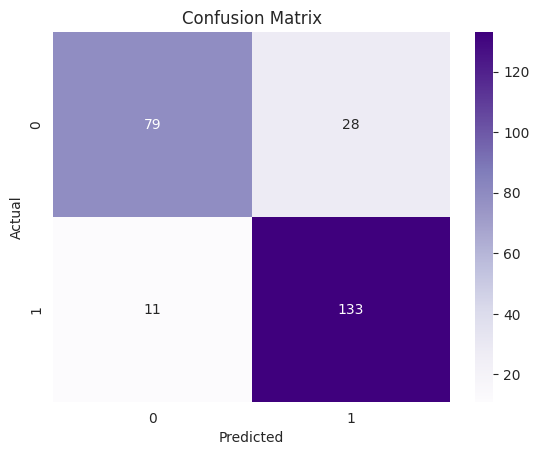

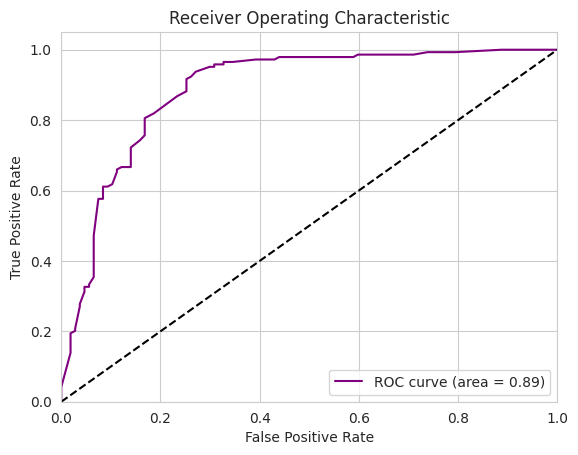

In [103]:
# Perform hyperparameter tuning using RandomizedSearchCV with the XGBoost classifier
cv_xgb = RandomizedSearchCV(estimator=xgb_clf, 
                            param_distributions=param_grid,
                            scoring='f1',
                            n_iter=200, #200 iterations
                            cv=5,
                            random_state=42)
# Fit the RandomizedSearchCV to the training data
cv_xgb.fit(X_train, y_train)

print('Best Parameters:', cv_xgb.best_estimator_.get_params())

# Loop over the training, validation, and test datasets to evaluate the best XGBoost model
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Evaluate
    basic_class_evaluate(model=cv_xgb.best_estimator_, 
    X=x, y=y,
    nsplit=nsplit,
    model_name='xg-boost-f1')

# Extract feature importances from the best estimator of the tuned XGBoost model
importances = cv_xgb.best_estimator_.feature_importances_
print(importances)

# Plotting the feature importances 
sns.barplot(x=X.columns.tolist(), y=importances, color='rebeccapurple')
plt.title('Feature Importances')
plt.suptitle('XG Boost - F1', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.savefig('plots/analysis/feature_importances_xg_f1.png')
plt.show()

# Detailed evaluation
predicted = cv_xgb.predict(X_test)
detailed_evaluate(model = cv_xgb, X_test=X_test[tree_feature_cols], y_test=y_test, y_pred=predicted)

## Evaluation

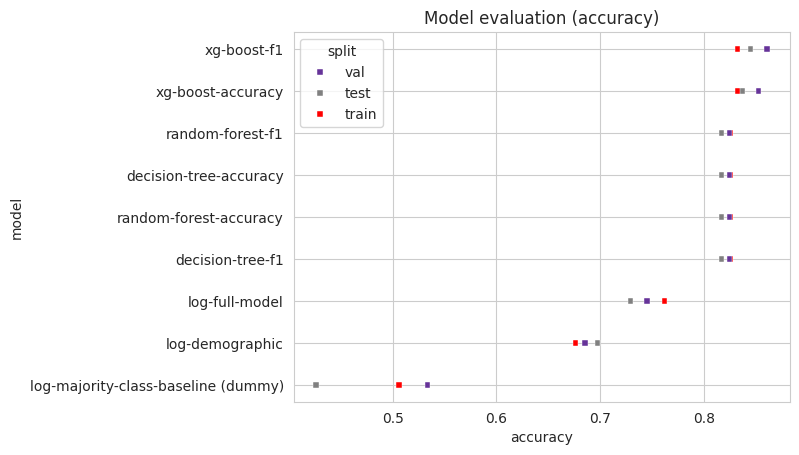

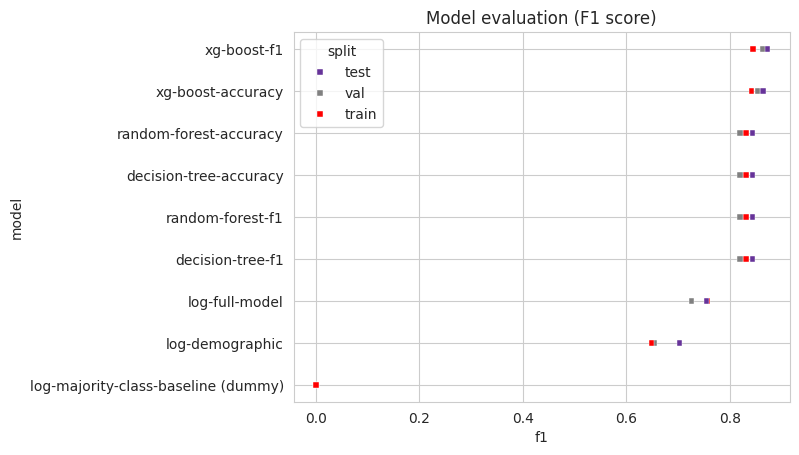

In [104]:
# Converting the performance metrics into a DataFrame
perf_df = pd.DataFrame(performances)
# Set style for plots
sns.set_style('whitegrid')
# Create a scatter plot for model evaluation based on accuracy
sns.scatterplot(data=perf_df.sort_values(by='accuracy', ascending=False), 
                y='model', 
                x='accuracy', 
                marker='s', 
                hue='split',
                palette=['rebeccapurple', 'grey', 'red'],
                s=15) # Change this if you want smaller dots
plt.title('Model evaluation (accuracy)')
plt.savefig('plots/analysis/all_model_perf_acc.png')
plt.show()

# Convert the performance metrics into a DataFrame 
perf_df = pd.DataFrame(performances)
# Set style for plots
sns.set_style('whitegrid')
# Create a scatter plot for model evaluation based on f1
sns.scatterplot(data=perf_df.sort_values(by='f1', ascending=False), 
                y='model', 
                x='f1', 
                marker='s', 
                hue='split',
                palette=['rebeccapurple', 'grey', 'red'],
                s=15) # Change this if you want smaller dots
plt.title('Model evaluation (F1 score)')
plt.savefig('plots/analysis/all_model_perf_f1.png')
plt.show()